# Calculo de jaccard

### Preparacion de archivos

In [1]:
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

def build_lagoon_matrix_from_csv(file):
    """
    Read a CSV with structure:
    Especie, Termas L1, Termas C, ..., Espinillo L2, Rotiferos, Copepodos, Cladoceros
    
    Returns:
        df_lagoons: DataFrame (index=Especie, columns=lagunas) with 0/1 presence.
    """
    df = pd.read_csv(file)
    
    # Drop non-site columns
    to_drop = ["Rotiferos", "Copepodos", "Cladoceros"]
    df = df.drop(columns=to_drop, errors="ignore")
    
    # Binarize (presence/absence)
    df_bin = df.copy()
    df_bin.iloc[:, 1:] = (df_bin.iloc[:, 1:] > 0).astype(int)
    
    # Species as index
    df_bin = df_bin.set_index("Especie")
    
    # Identify lagoons from column names (e.g. "Viale L1" -> "Viale")
    site_cols = df_bin.columns
    lagoon_names = [col.split()[0] for col in site_cols]   # take first word
    unique_lagoons = sorted(set(lagoon_names))
    
    # Pool sites within each lagoon (logical OR across L1, C, L2)
    lagoon_data = {}
    for lagoon in unique_lagoons:
        lagoon_cols = [c for c in site_cols if c.startswith(lagoon + " ")]
        # OR across the 3 sites → 1 if present in ANY site
        lagoon_data[lagoon] = df_bin[lagoon_cols].max(axis=1)
    
    df_lagoons = pd.DataFrame(lagoon_data)
    
    return df_lagoons

In [4]:
def jaccard_dendrogram_from_lagoon_matrix(
    df_lagoons,
    season_label="",
    out_csv=None,
    color_threshold=0.75,     # umbral de distancia para colorear clusters
    figsize=(10, 6),
    dpi=150
):
    """
    df_lagoons: DataFrame con index=Especie, columns=Lagunas (0/1)
    color_threshold: altura (distancia) a partir de la cual se separan colores de clusters.
                     Distancia = 1 - Jaccard (0 = idéntico, 1 = totalmente distinto).
    """

    # Lagunas en filas, especies en columnas
    data = df_lagoons.T
    lagoons = data.index
    n = len(data)

    # Matriz de similitud Jaccard (laguna x laguna)
    matriz = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matriz[i, j] = jaccard_score(
                data.iloc[i],
                data.iloc[j],
                average="binary",
                zero_division=0
            )

    df_jaccard = pd.DataFrame(matriz, index=lagoons, columns=lagoons)

    # Guardar CSV si se pide
    if out_csv is not None:
        df_jaccard.to_csv(out_csv)

    # Similitud -> distancia
    df_dist = 1 - df_jaccard

    # Matriz cuadrada -> vector condensado
    dist_array = squareform(df_dist.values)

    # UPGMA (average linkage)
    linked = linkage(dist_array, method="average")

    # --- GRÁFICO ---
    plt.figure(figsize=figsize, dpi=dpi)

    dendrogram(
        linked,
        labels=df_jaccard.index,
        leaf_rotation=90,
        leaf_font_size=10,
        color_threshold=color_threshold,   # umbral para cambiar colores
        above_threshold_color="gray"       # ramas por encima del umbral en gris
    )

    # Línea horizontal de corte visual
    plt.axhline(y=color_threshold, color="red", linestyle="--", linewidth=1)

    # Título y ejes
    title = (
        f"Agrupamiento lagunas (Jaccard) - {season_label}"
        if season_label
        else "Agrupamiento lagunas (Jaccard)"
    )
    plt.title(title, fontsize=14)
    plt.ylabel("Distancia (1 - Jaccard)", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=9)
    plt.tight_layout()

    # Nombre de archivo amigable
    safe_label = season_label if season_label else "dendrograma"
    safe_label = re.sub(r"\s+", "_", safe_label.lower())
    plt.savefig(f"listos/{safe_label}_jaccard.png", bbox_inches="tight")
    plt.show()

    return df_jaccard


=== Invierno ===


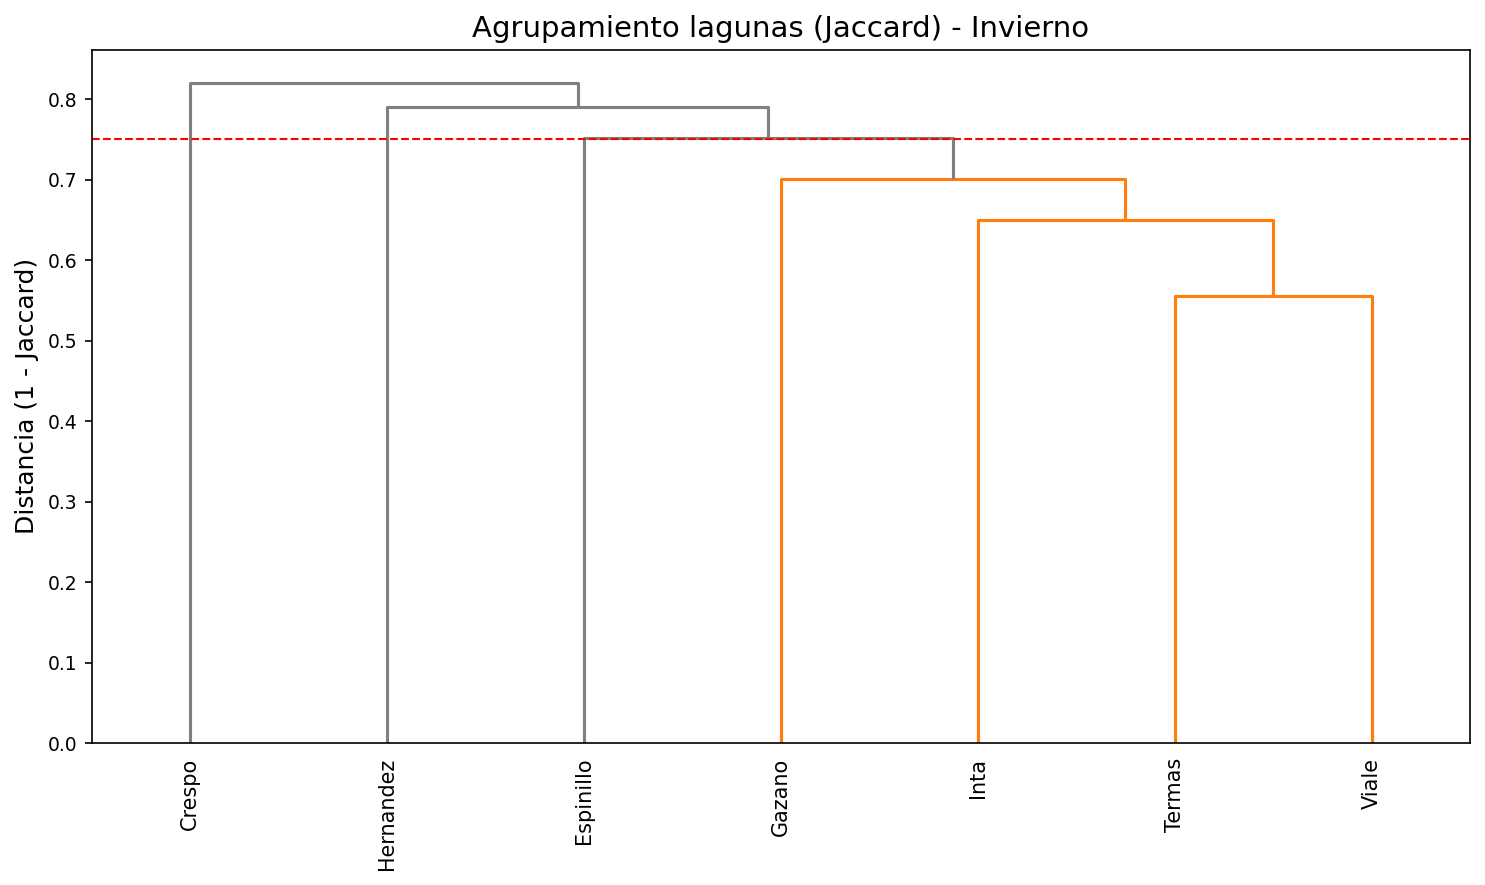


=== Primavera ===


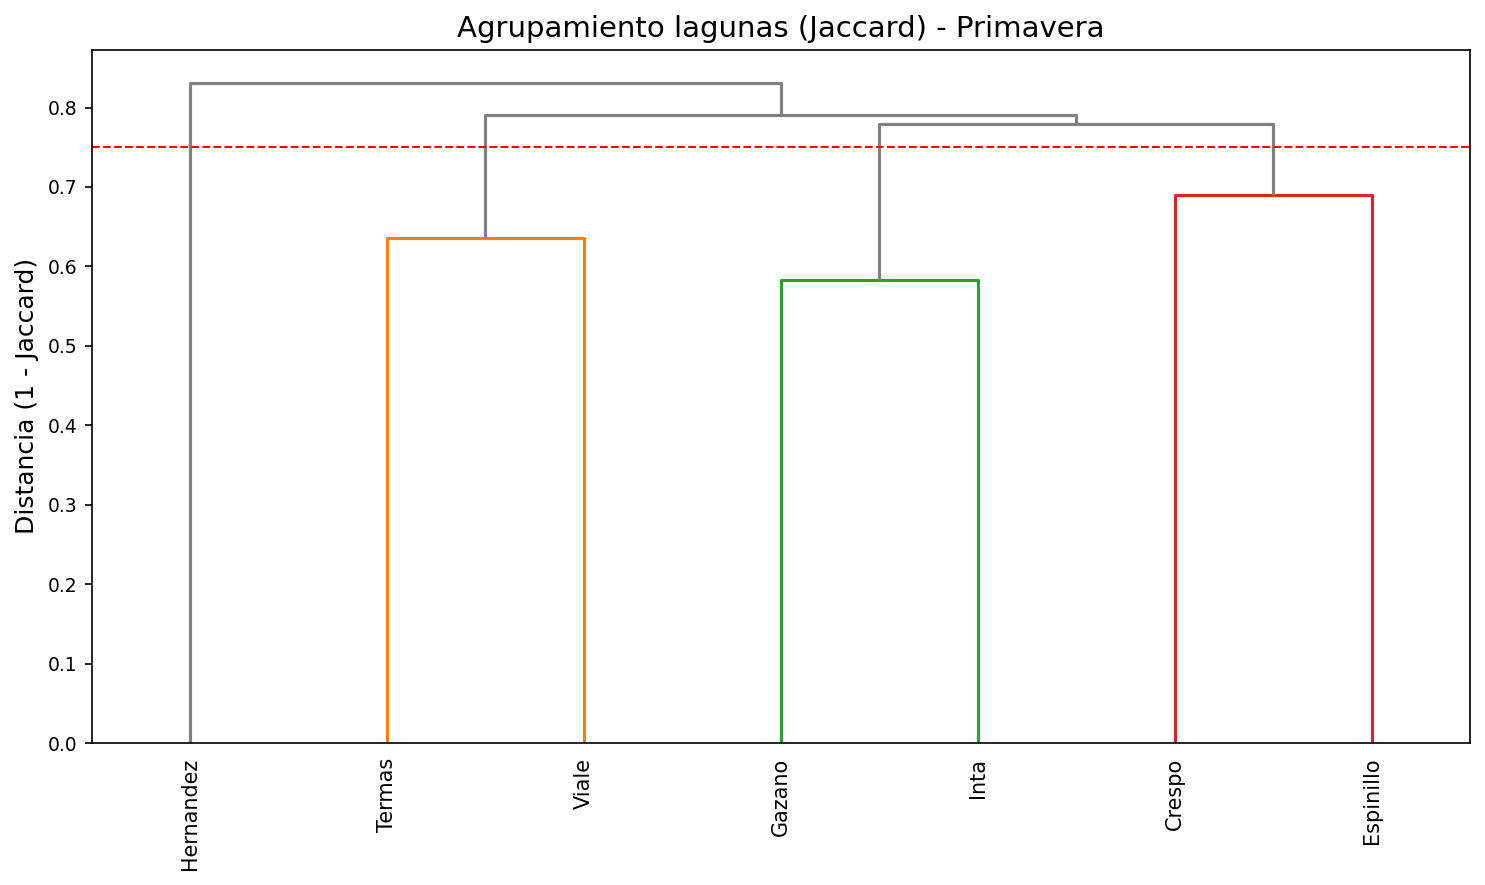


=== Verano ===


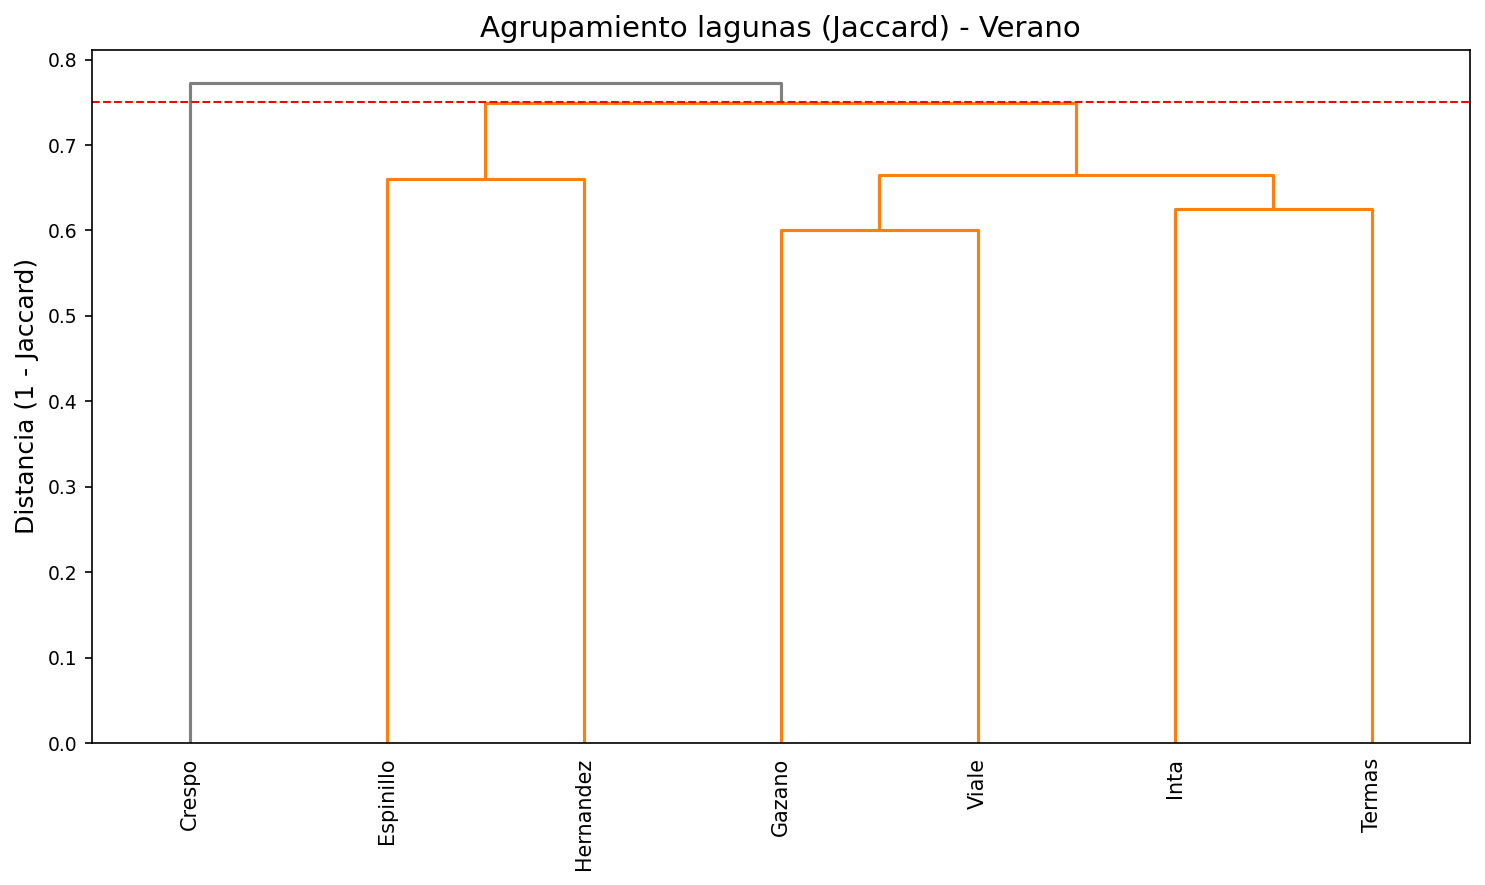


=== Otoño ===


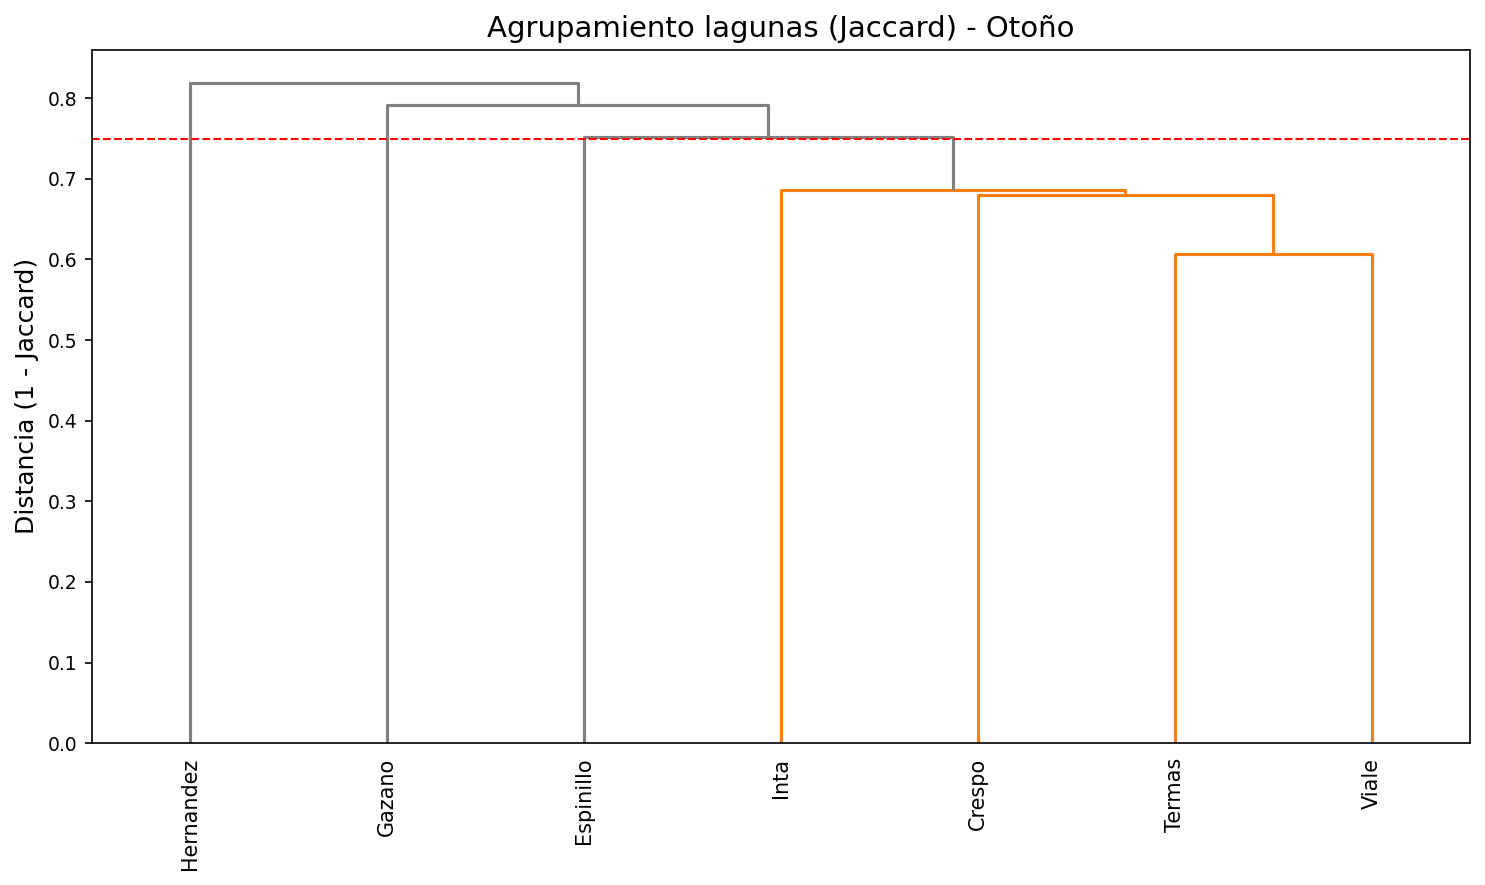

In [5]:
# Example paths: change to your real file names
season_files = {
    "Invierno":  "listos/invierno.csv",
    "Primavera": "listos/primavera.csv",
    "Verano":    "listos/verano.csv",
    "Otoño":     "listos/otoño.csv",
}

jaccard_results = {}

for season, path in season_files.items():
    print(f"\n=== {season} ===")
    df_lagoons = build_lagoon_matrix_from_csv(path)
    df_jac = jaccard_dendrogram_from_lagoon_matrix(
        df_lagoons,
        season_label=season,
        out_csv=f"listos/jaccard_lagunas_{season.lower()}.csv"
    )
    jaccard_results[season] = df_jac


In [6]:
def build_annual_lagoon_matrix(season_files):
    """
    season_files: dict con {nombre_estacion: ruta_csv}
    
    Devuelve:
        df_annual: DataFrame (index=Especie, columns=Lagunas) binario (0/1)
        donde una especie = 1 si estuvo presente en esa laguna
        en AL MENOS una estación del año.
    """
    dfs = []
    for season, path in season_files.items():
        df_lag = build_lagoon_matrix_from_csv(path)  # Especie x Lagunas (0/1)
        dfs.append(df_lag)

    # Apilamos todas las estaciones una debajo de la otra
    combined = pd.concat(dfs, axis=0)  # muchas filas, mismas columnas (lagunas)

    # Para cada especie, tomamos el máximo por fila (OR lógico entre estaciones)
    df_annual = combined.groupby(combined.index).max()

    return df_annual


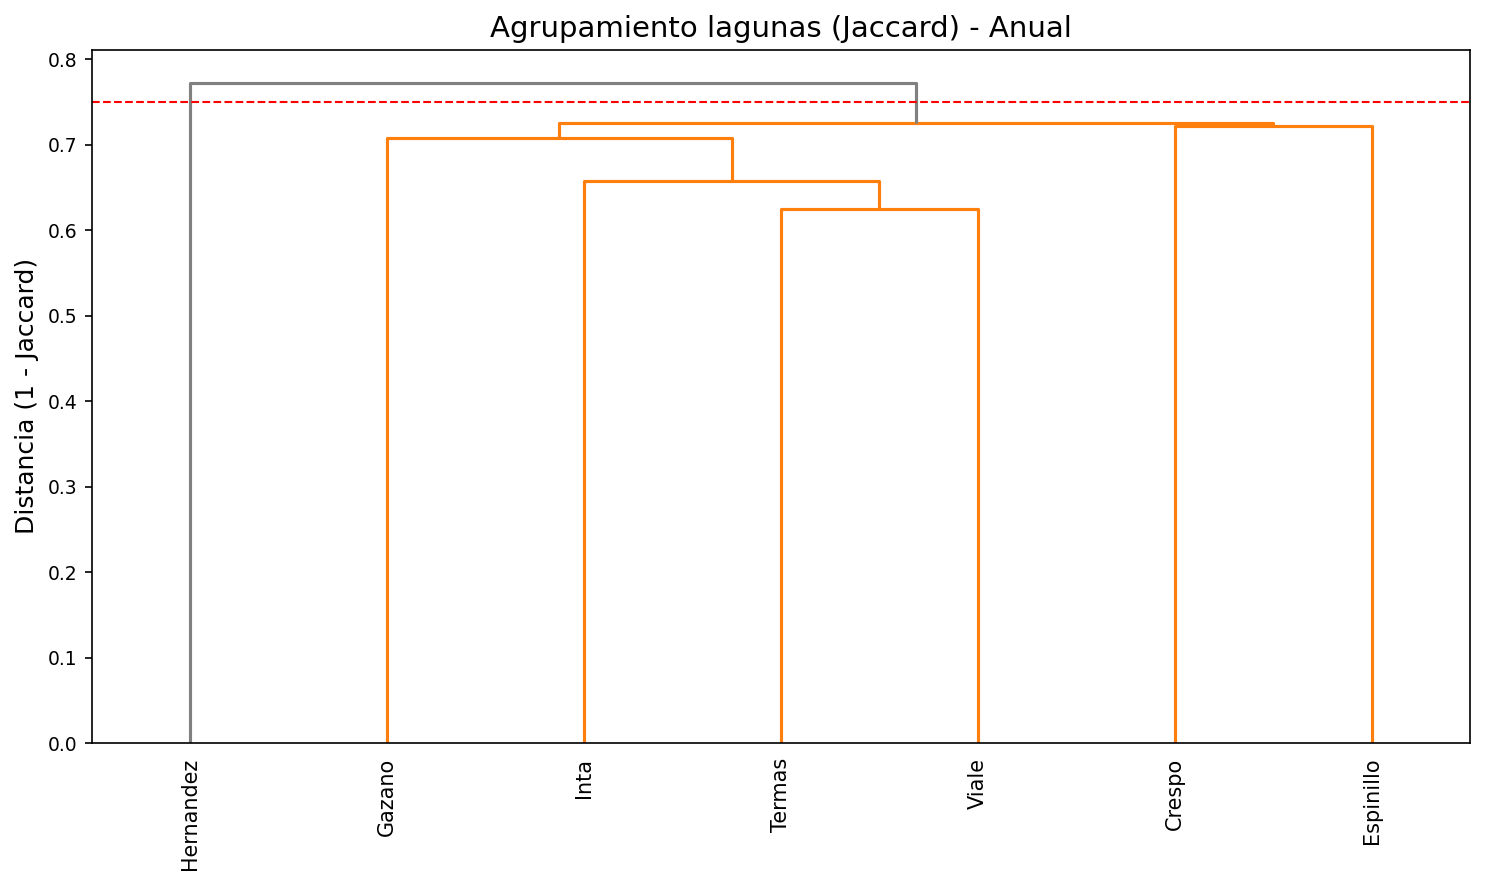

In [7]:
season_files = {
    "Invierno":  "listos/invierno.csv",
    "Primavera": "listos/primavera.csv",
    "Verano":    "listos/verano.csv",
    "Otoño":     "listos/otoño.csv",
}

# Construimos comunidad anual por laguna
df_annual_lagoons = build_annual_lagoon_matrix(season_files)

# Dendrograma de similitud anual entre lagunas
df_jaccard_anual = jaccard_dendrogram_from_lagoon_matrix(
    df_annual_lagoons,
    season_label="Anual",
    out_csv="listos/jaccard_lagunas_anual.csv"
)


In [21]:
df_annual_lagoons

,Crespo,Espinillo,Gazano,Hernandez,Inta,Termas,Viale
Especie,,,,,,,
Alona cf. glabra,1.0,0.0,0.0,0.0,1.0,0.0,0.0
Alona cf. grabla,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Alona sp.,1.0,1.0,0.0,1.0,0.0,0.0,1.0
Alona sp1.,0.0,0.0,0.0,1.0,0.0,0.0,0.0
Anuraeopsis fissa,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
Trichocerca grandis,0.0,0.0,1.0,0.0,1.0,1.0,1.0
Trichocerca sp,1.0,0.0,0.0,0.0,1.0,1.0,1.0
Trichocerca sp.,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
shared_species = df_annual_lagoons[
    (df_annual_lagoons["Hernandez"] == 1) &
    (df_annual_lagoons["Crespo"] == 1)
].index.tolist()

print(f"Especies compartidas ({len(shared_species)}):")
print(shared_species)


Especies compartidas (27):
['Alona sp. ', 'Bedelloideos', 'Brachionus angularis ', 'Brachionus havanaensis ', 'Brachionus plicatilis ', 'Cephalodella sp1.', 'Chydorido sp4.', 'Colurella sp. ', 'Copepdodo Ciclopoideo sp1.', 'Copepoditos ', 'Copepodo ciclopodo sp1.', 'Keratella tropica ', 'Lecane bulla', 'Lecane bulla ', 'Lecane closterocerca', 'Lecane hamata', 'Lecane luna', 'Lecane luna ', 'Lecane lunaris ', 'Lepadella cf. ovalis', 'Lepadella sp. ', 'Lepadella sp1.', 'Macrothrix sp.  ', 'Mytilina ventralis  ', 'Nauplios', 'Poliarthra sp. ', 'Poliarthra sp.1']


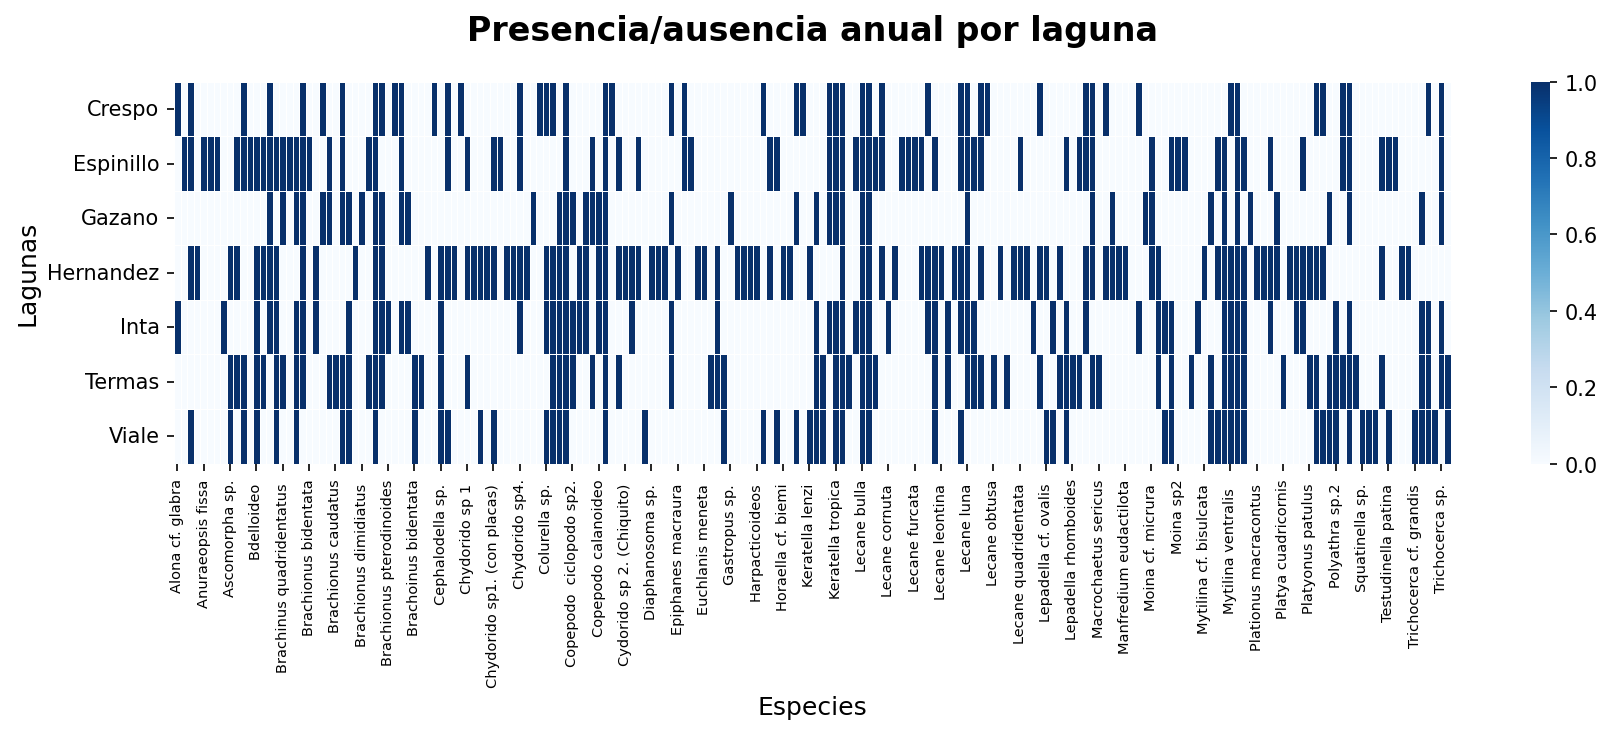

In [16]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(12, 5), dpi=150)

sns.heatmap(
    df_annual_lagoons.T,
    cmap="Blues",
    cbar=True,
    linewidths=0.3,
    linecolor="white",
    ax=ax
)

ax.set_title("Presencia/ausencia anual por laguna", fontsize=16, weight="bold", pad=20)
ax.set_xlabel("Especies", fontsize=12)
ax.set_ylabel("Lagunas", fontsize=12)

# Mejorar etiquetas
ax.tick_params(axis="x", rotation=90, labelsize=7)
ax.tick_params(axis="y", labelsize=10)

# Ajustar márgenes para etiquetas largas
fig.tight_layout()

fig.savefig("heatmap_estetico.png")
plt.show()
